In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from src.scripts.article_to_country import *

from src.data.dataloader import *
from src.utils.plots import *
from src.utils.functions import *
from src.scripts.articles_clicks_links import click_count_in_paths
from country_list import countries_for_language
from itertools import combinations
import plotly.express as px


In [3]:
results = {}
country_data = pd.read_csv('data/country_data.csv', index_col=0)
counts = filter_top_k(country_data, k=2, N=1)
total_number_of_articles = len(counts)

nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")
results["naïve"] = (total_number_of_articles - len(nan_df)) / total_number_of_articles

refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with naive + llama: {len(nan_df)}")
results["naïve + LlaMa"] = (total_number_of_articles - len(nan_df)) / total_number_of_articles

qwen_country_data = pd.read_csv('data/country_data_full_qwen.csv', index_col=0)
qwen_missing = len(qwen_country_data[qwen_country_data["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with QWEN: {qwen_missing}")
results["Qwen"] = (total_number_of_articles - qwen_missing) / total_number_of_articles


llama_country_data = pd.read_csv('data/country_data_full_llama.csv', index_col=0)
llama_missing = len(llama_country_data[llama_country_data["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with LLAMA: {llama_missing}")
results["LlaMa"] = (total_number_of_articles - llama_missing) / total_number_of_articles


Number of articles with no countries before completion with llama: 1412
Number of articles with no countries after completion with naive + llama: 283
Number of articles with no countries after completion with QWEN: 2905
Number of articles with no countries after completion with LLAMA: 479


In [4]:

# qwen_country_data = pd.read_csv('data/country_data_full_qwen.csv', index_col=0)
# countries = list(dict(countries_for_language('en')).values())

# for idx, row in qwen_country_data.iterrows():
#     if not pd.isna(row['Top_1_name']):
#         for country in countries:
#             if country.lower() in row['Top_1_name'].lower():
#                 qwen_country_data.at[idx, 'Top_1_name'] = country.lower()
#                 break
# qwen_country_data.to_csv('data/country_data_full_qwen.csv')

In [5]:

# qwen_country_data = pd.read_csv('data/country_data_full_llama.csv', index_col=0)
# countries = list(dict(countries_for_language('en')).values())

# for idx, row in qwen_country_data.iterrows():
#     if not pd.isna(row['Top_1_name']):
#         for country in countries:
#             if country.lower() in row['Top_1_name'].lower():
#                 qwen_country_data.at[idx, 'Top_1_name'] = country.lower()
#                 break
# qwen_country_data.to_csv('data/country_data_full_llama.csv')

In [6]:
fig = px.bar(x=results.keys(), y=results.values())
fig.update_layout(title="Proportion of articles assigned to a country")
fig.update_yaxes(range=[0, 1])
fig.show()
fig.write_html("test_plt.html")

Text(0, 0.5, '% of articles assigned to a country')

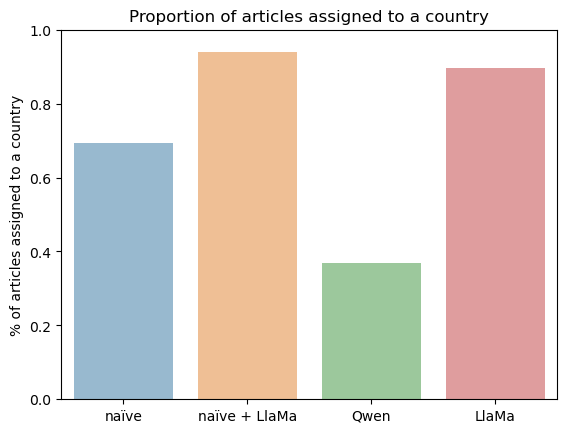

In [7]:
sns.barplot(x=results.keys(), y=results.values(),  alpha=0.5, hue=results.keys(), )
plt.ylim(0, 1)
plt.title("Proportion of articles assigned to a country")
plt.ylabel("% of articles assigned to a country")

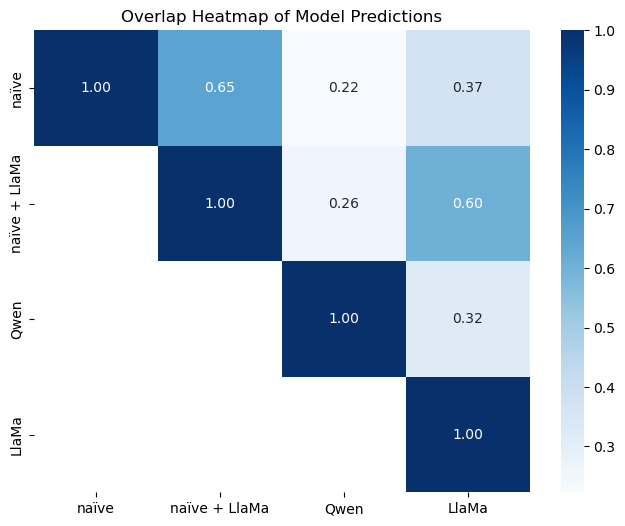

In [8]:
models = {
    "naïve": counts,
    "naïve + LlaMa": refined_data,
    "Qwen": qwen_country_data,
    "LlaMa": llama_country_data
}

heatmap_data = pd.DataFrame(index=models, columns=models)

for model in models.keys():
    heatmap_data.loc[model, model] = 1.0

for model1, model2 in combinations(models.keys(), 2):
    df_1 = models[model1]
    df_2 = models[model2]
    overlap = (df_1["Top_1_name"] == df_2["Top_1_name"]).sum() / total_number_of_articles
    heatmap_data.loc[model1, model2] = overlap
    # heatmap_data.loc[model2, model1] = overlap

# Convert to float
heatmap_data = heatmap_data.astype(float)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title("Overlap Heatmap of Model Predictions")
plt.show()

In [9]:
articles = pd.DataFrame(counts.index)

subset_1 = articles.sample(10, random_state=0).values.flatten().tolist()
subset_2 = articles.sample(10, random_state=1).values.flatten().tolist()
subset_3 = articles.sample(10, random_state=2).values.flatten().tolist()
subset_4 = articles.sample(10, random_state=3).values.flatten().tolist()
subset_5 = articles.sample(10, random_state=4).values.flatten().tolist()
subset_6 = articles.sample(10, random_state=5).values.flatten().tolist()

In [10]:
claire = subset_1 + subset_3
theo = subset_2 + subset_4
oriane = subset_1 + subset_4
bryan = subset_2 + subset_5
jeremy = subset_3 + subset_5

In [11]:
claire = pd.DataFrame(index=claire, columns=["country"])
theo = pd.DataFrame(index=theo, columns=["country"])
oriane = pd.DataFrame(index=oriane, columns=["country"])
bryan= pd.DataFrame(index=bryan, columns=["country"])
jeremy = pd.DataFrame(index=jeremy, columns=["country"])

In [12]:
# pd.DataFrame(claire).to_csv("claire.csv")
# pd.DataFrame(theo).to_csv("theo.csv")
# pd.DataFrame(oriane).to_csv("oriane.csv")
# pd.DataFrame(bryan).to_csv("bryan.csv")
# pd.DataFrame(jeremy).to_csv("jeremy.csv")

# countries = list(dict(countries_for_language('en')).values())
# pd.DataFrame(countries).to_csv("countries.csv")

In [13]:
annotation_path = "./data/annotated/"

claire = pd.read_csv(annotation_path + "subset_claire.csv", index_col=0, na_values="None")
theo = pd.read_csv(annotation_path + "subset_theo.csv", index_col=0, na_values="None")
oriane = pd.read_csv(annotation_path + "subset_oriane.csv", index_col=0, na_values="None")
bryan = pd.read_csv(annotation_path + "subset_bryan.csv", index_col=0, na_values="None")
jeremy = pd.read_csv(annotation_path + "subset_jeremy.csv", index_col=0, na_values="None")

In [14]:
subset_1_c = claire[:10]
subset_3_c = claire[10:]

subset_2_t = theo[:10]
subset_4_t = theo[10:]

subset_1_o = oriane[:10]
subset_4_o = oriane[10:]

subset_2_b = bryan[:10]
subset_5_b = bryan[10:]

subset_3_j = jeremy[:10]
subset_5_j = jeremy[10:]

In [15]:
comparison1 = subset_1_c["country"].str.lower().fillna("nan") == subset_1_o["country"].str.lower().fillna("nan")
comparison1.sum()

8

In [16]:
comparison2 = subset_2_t["country"].str.lower().fillna("nan") == subset_2_b["country"].str.lower().fillna("nan")
comparison2.sum()

6

In [17]:
comparison3 = subset_3_c["country"].str.lower().fillna("nan") == subset_3_j["country"].str.lower().fillna("nan")
comparison3.sum()

8

In [18]:
comparison4 = subset_4_t["country"].str.lower().fillna("nan") == subset_4_o["country"].str.lower().fillna("nan")
comparison4.sum()

5

In [19]:
comparison5 = subset_5_b["country"].str.lower().fillna("nan") == subset_5_j["country"].str.lower().fillna("nan")
comparison5.sum()

9

In [20]:
df = pd.concat([
    subset_1_c.loc[comparison1],
    subset_2_b.loc[comparison2],
    subset_3_c.loc[comparison3],
    subset_4_t.loc[comparison4],
    subset_5_b.loc[comparison5]
], ignore_index=False)


In [21]:
df.to_csv("data/annotated/consensus.csv")

In [22]:
models = {
    "naïve": counts,
    "naïve + LlaMa": refined_data,
    "Qwen": qwen_country_data,
    "LlaMa": llama_country_data
}

values = []
for model in models.keys():
    agreement_value = (models[model].loc[df.index]["Top_1_name"] == df["country"].str.lower().fillna("nan")).sum() / len(df)
    values.append(agreement_value)
    
px.bar(
    x=models.keys(), 
    y=values, 
    color=models.keys(),
    title="Agreement between annotators and models", 
    labels={"x": "Model", "y": "Agreement"}
    ).update_yaxes(range=[0, 1]).show()

    

In [23]:
new_df = llama_country_data.loc[df.index]
new_df["annotation"] = df["country"].str.lower().fillna("nan")

In [24]:
new_df[["Top_1_name", "annotation"]]

,Top_1_name,annotation
Hadrian%27s_Wall,united kingdom,united kingdom
Globe_Theatre,united kingdom,united kingdom
List_of_monarchs_in_the_British_Isles,united kingdom,united kingdom
Aleksandr_Vasilevsky,russia,russia
Pyongyang,north korea,north korea
Ivory,afghanistan,nan
Beep_%28SWBLW%29,united states,united states
Fermium,NaN,nan
Dwight_D._Eisenhower,united states,united states
Invasion,grenada,nan
